In [1]:
from ultralytics import YOLO

from roboflow import Roboflow
import os
from tqdm import tqdm

In [3]:
rf = Roboflow(api_key="nz2w1UFnyFrM7e73WOzh")
project = rf.workspace("nyu-figsb").project("basketballandhoop")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to basketballAndHoop-2 in yolov8:: 100%|██████████| 2866/2866 [00:05<00:00, 567.80it/s] 


# Add "Person" to annotations

In [6]:
model = YOLO("yolov8l.pt")
dataset_root_dir = "basketballAndHoop-2"
for group in ["train", "test", "valid"]:
    data_loc = f"{dataset_root_dir}/{group}/images"
    images = os.listdir(data_loc)
    images = [os.path.join(data_loc, image) for image in images]
    for i in tqdm(range(0, len(images), 32)):
        result = model(images[i:i+32], verbose = False, conf = 0.35)
        img_names = [os.path.basename(img) for img in images[i:i+32]]
        
        for r, img_name in zip(result, img_names):
            box = r.boxes
            classes = box.cls.cpu().numpy().astype(int)
            xywhn = box.xywhn.cpu().numpy()
            person = [pred for pred in zip(classes, xywhn) if pred[0] == 0]
            
            label_path = f"{dataset_root_dir}/{group}/labels/{img_name[:-4]}.txt"
            
            with open(label_path, "a") as f:
                for p in person:
                    f.write(f"\n2 {p[1][0]} {p[1][1]} {p[1][2]} {p[1][3]}")

            
    

100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


## drop the Made class

In [ ]:
dataset_root_dir = "basketballAndHoop-1"

# drop the "made" class (2) and replace "person" as 3
for group in ["train", "test", "valid"]:
    data_loc = f"basketballAndHoop-1/{group}/labels"
    labels = os.listdir(data_loc)
    labels = [os.path.join(data_loc, label) for label in labels]
    
    for label in labels:
        with open(label, "r") as f:
            lines = f.readlines()
        
        with open(label, "w") as f:
            for line in lines:
                if line[0] == "2":
                    continue
                if line[0] == "0":
                    f.write(f"3{line[1:]}")
                else:
                    f.write(line)
        
        


In [ ]:
import cv2
import numpy as np
from PIL import Image

In [ ]:
def visualize_bounding_box(image_path, label_path):
    # draw the bounding box in yolo format (x_center, y_center, width, height)
    # bouding box coordinates are in label_path
    
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip().split()[1:]
            if not line:
                continue
            x_center, y_center, width, height = map(float, line)
            
            x_center, y_center, width, height = x_center * w, y_center * h, width * w, height * h
            x1, y1, x2, y2 = x_center - width/2, y_center - height/2, x_center + width/2, y_center + height/2
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
    return image

    

In [10]:
image_path = 'basketballAndHoop-1/train/images/-Zfak_aDbSg_01_jpg.rf.1cd69565a1ef9b4cc766e668e156ffd0.jpg'
label_path = 'basketballAndHoop-1/train/labels/-Zfak_aDbSg_01_jpg.rf.1cd69565a1ef9b4cc766e668e156ffd0.txt'

image = visualize_bounding_box(image_path, label_path)


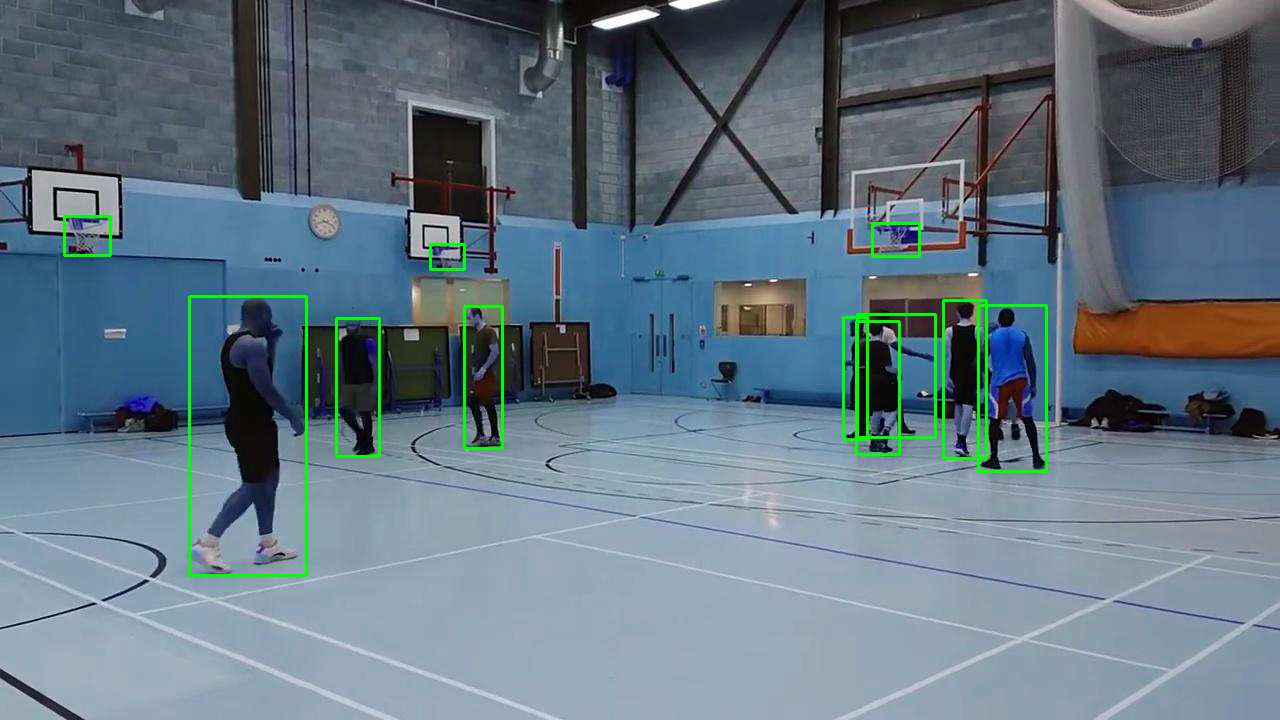

In [13]:
Image.fromarray(image)

# Train

In [2]:
model = YOLO("weights/best.pt")
model.train(data = "basketballAndHoop-2/data.yaml", 
            epochs = 250, 
            batch = 32, 
            # imgsz = 640, 
            optimizer = "SGD",
            save_period=50,
            lr0 = 0.0005,
            lrf = 0.01,
            workers = 10,
            device = 0,
            patience = 30,
            # resume = True
            # mosaic = 0.3
            degrees = 10
            )

New https://pypi.org/project/ultralytics/8.1.47 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.14 torch-2.1.2 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
engine/trainer: task=detect, mode=train, model=weights/best.pt, data=basketballAndHoop-2/data.yaml, epochs=250, patience=30, batch=32, imgsz=736, save=True, save_period=50, cache=False, device=0, workers=10, project=None, name=None, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augmen